In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [33]:
df = pd.read_csv("/home/jose/Programming/aiml/Data/houston-AQI-weather/filled-in-data/Channelview C15-AH115.csv")

df.head(5)

,Unnamed: 0,Date,AQI,air_temp,dew_point_temp,sea_level_pressure,visibility,wind_speed
0,0,2001-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2001-07-02,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2001-07-03,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2001-07-04,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2001-07-05,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
### Clean the data

# TODO: Linear interpolation instead?
def clean_df(d):
    d = d.dropna()
    del d['Unnamed: 0']
    d = d[~d.isin(['NV']).any(axis=1)]
    d.head()

df = clean_df(df)

,Date,AQI,air_temp,dew_point_temp,sea_level_pressure,visibility,wind_speed
3847,2012-01-01,37,17.0,9.0,1027.0,9000.0,6.2500
3848,2012-01-02,39,15.0,1.0,1035.0,10000.0,5.0000
3849,2012-01-03,37,12.0,0.0,1033.0,10000.0,4.0625
3850,2012-01-04,25,20.0,11.0,1025.0,10000.0,2.8125
3851,2012-01-05,30,21.0,15.0,1024.0,10000.0,1.5625


In [35]:
x_axis = (matplotlib.dates.datestr2num(df.Date.values))

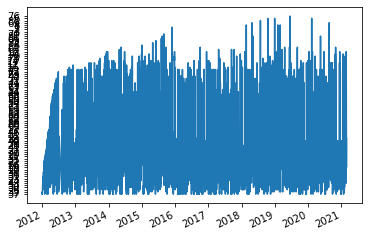

In [36]:
plt.plot_date(x_axis, df.AQI.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

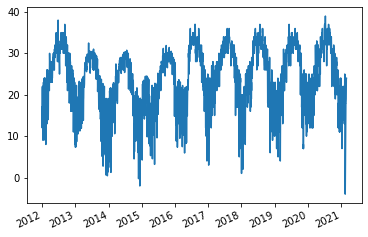

In [5]:
plt.plot_date(x_axis, df.air_temp.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

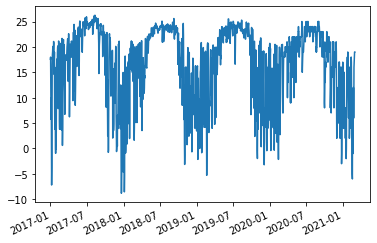

In [13]:
plt.plot_date(x_axis, df.dew_point_temp.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

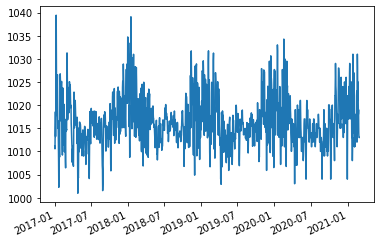

In [14]:
plt.plot_date(x_axis, df.sea_level_pressure.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

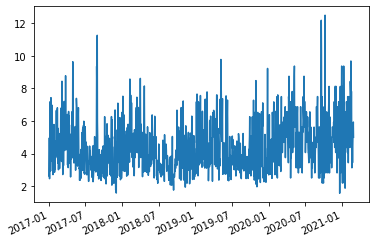

In [15]:
plt.plot_date(x_axis, df.wind_speed.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

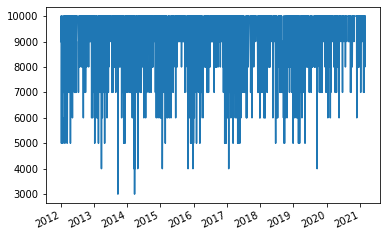

In [6]:
plt.plot_date(x_axis, df.visibility.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

In [37]:
x_data = df[['air_temp', 'dew_point_temp', 'sea_level_pressure', 'wind_speed']].values
y_data = df.AQI.values

print(x_data)

[[1.7000e+01 9.0000e+00 1.0270e+03 6.2500e+00]
 [1.5000e+01 1.0000e+00 1.0350e+03 5.0000e+00]
 [1.2000e+01 0.0000e+00 1.0330e+03 4.0625e+00]
 ...
 [2.3000e+01 1.7000e+01 1.0140e+03 4.3750e+00]
 [2.4000e+01 1.8000e+01 1.0140e+03 4.3750e+00]
 [2.4000e+01 1.9000e+01 1.0140e+03 4.3750e+00]]


In [38]:
train_test_split = 0.8

num_train = int(len(x_data) * train_test_split)
num_test = len(x_data) - num_train

x_train = x_data[0:num_train]
x_test = x_data[num_train:]

# Expanding dimension to (None, 1) (to a vector) instead of just an array of shape (None,)
# Used in order to feed into the MinMaxScaler (does not support 1D arrays)
y_train = np.expand_dims(y_data[:num_train], axis=1)
y_test = np.expand_dims(y_data[num_train:], axis=1)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(type(y_train))

(2592, 4) (648, 4) (2592, 1) (648, 1)
<class 'numpy.ndarray'>


In [39]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

print(y_train)

[['37']
 ['39']
 ['37']
 ...
 ['29']
 ['48']
 ['48']]


In [40]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input features
        x_shape = (batch_size, sequence_length, x_train.shape[1])
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output
        y_shape = (batch_size, sequence_length, 1)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [41]:
batch_size = 32
# 7 days in a week, 8 times
sequence_length = 7 * 16

generator = batch_generator(batch_size, sequence_length)
x_batch, y_batch = next(generator)
print(x_batch.shape, y_batch.shape)

(32, 112, 4) (32, 112, 1)


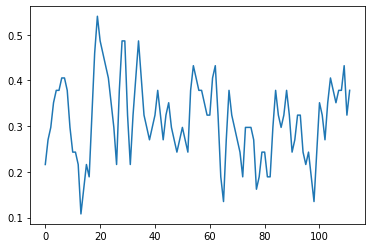

In [42]:
plt.plot(x_batch[0, :, 2])


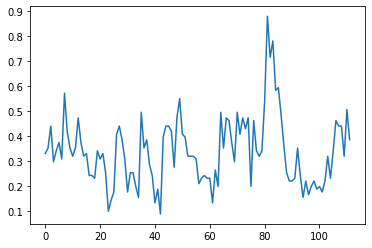

In [43]:
plt.plot(y_batch[1, :, 0])

In [44]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [45]:
model = Sequential()

model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, x_test.shape[1],)))
model.add(Dense(1, activation='sigmoid')) # TODO change this

In [46]:
warmup_steps = 12

def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [47]:
model.compile(loss=loss_mse_warmup, optimizer=RMSprop(lr=1e-3))

/home/jose/.local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [48]:
path_checkpoint = '../checkpoints_weather_non_nan/'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [49]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [50]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [51]:
callbacks = [callback_early_stopping,
             callback_reduce_lr]

In [52]:
model.fit(x=generator,
            epochs=20,
            steps_per_epoch=100,
            validation_data=validation_data,
            callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - 6s 40ms/step - loss: 0.0199 - val_loss: 0.0166
Epoch 2/20
100/100 [==============================] - 4s 38ms/step - loss: 0.0175 - val_loss: 0.0133
Epoch 3/20
100/100 [==============================] - 4s 38ms/step - loss: 0.0171 - val_loss: 0.0124
Epoch 4/20
100/100 [==============================] - 4s 41ms/step - loss: 0.0166 - val_loss: 0.0129

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/20
100/100 [==============================] - 4s 42ms/step - loss: 0.0153 - val_loss: 0.0125

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 6/20
100/100 [==============================] - 4s 41ms/step - loss: 0.0137 - val_loss: 0.0121
Epoch 7/20
100/100 [==============================] - 4s 40ms/step - loss: 0.0134 - val_loss: 0.0122
Epoch 8/20
100/100 [==============================] - 4s 38ms/step - loss: 0.0128 - val_loss: 0.0123
Epoch 9/20
100/100 [========================

In [58]:
model.save(path_checkpoint)

INFO:tensorflow:Assets written to: ../checkpoints_weather_non_nan/assets
INFO:tensorflow:Assets written to: ../checkpoints_weather_non_nan/assets


In [54]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 57ms/step - loss: 0.0121


In [55]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))
    
    # Plot and compare the two signals.
    plt.plot(y_true[:, 0], label='true')
    plt.plot(y_pred_rescaled[:, 0], label='pred')
    plt.xlabel('Days')
    plt.ylabel('AQI')
    
    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
    
    # Plot labels etc.
    plt.legend()
    plt.show()

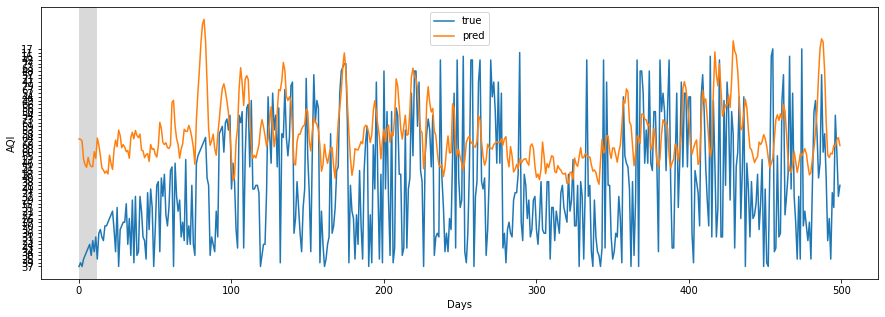

In [57]:
plot_comparison(start_idx=0, length=500, train=True)

In [ ]:
### TRAIN MODEL FOR ALL CSV FILES